# Dynamics systems and prepare data



## Voltera-Lotki equation is used to describe the dynamics of biological systems [Lotka–Volterra equations](https://en.wikipedia.org/wiki/Lotka-Volterra_equations) consists of two differential equations:

\begin{align*}
&\frac{\mathrm{d}x}{\mathrm{d}t} = ax - bxy,\\[1em]
&\frac{\mathrm{d}y}{\mathrm{d}t} = cxy - dy,\\[1em]
\end{align*}

with the following parameter values:
```python
a=1.0
b=0.3
c=0.2
d=1.0
```
and the initial value at time $t = 0$ with $x = 10$ and $y = 5$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.integrate import solve_ivp
from improve_dmdc import Improved_DMDc_new, Standard_DMDC
from controller import mpc_controller_lotka
import cvxpy as cp

np.random.seed(42)

In [2]:
# Lotka-Volterra parameters
a, b, c, d = 1.0, 0.3, 0.2, 1.0
integrator_keywords = {'rtol': 1e-12, 'method': 'LSODA', 'atol': 1e-12}

# Volterra-Lotka ODE
def ode_Volterra_Lotka(t, xy, uu):
    x, y = xy
    dx_dt = a * x - b * x * y
    dy_dt = c * x * y - d * y + uu
    return [dx_dt, dy_dt]

# Simulation function
def SciPy_VL(t_begin, t_end, x_init, y_init, t_space, u_con=None):
    if u_con is not None:
        u_interp = scipy.interpolate.interp1d(t_space, u_con, kind='previous', bounds_error=False, fill_value=(u_con[0], u_con[-1]))
        def ode_fun(t, xy):
            return ode_Volterra_Lotka(t, xy, u_interp(t))
    else:
        def ode_fun(t, xy):
            return ode_Volterra_Lotka(t, xy, 0.0)
    num_sol = solve_ivp(ode_fun, [t_begin, t_end], [x_init, y_init], **integrator_keywords, t_eval=t_space)
    return num_sol.y[0], num_sol.y[1]

# Simulation parameters
t_init, t_end, delta_t = 0, 100, 0.003
x_init, y_init = 10, 5
N_t = int((t_end - t_init) / delta_t) + 1
t_array = np.linspace(t_init, t_end, N_t)

# # # if we use random control input
u_con = 0.6 * (2 * np.sin(t_array) * np.sin(t_array / 10)) ** 2
x_solved, y_solved = SciPy_VL(t_begin=t_init, t_end=t_end, x_init=x_init, y_init=y_init, t_space=t_array, u_con=u_con)

# # if we assumed that we have known the model to design a perfect MPC
# x_sim = [np.array([x_init, y_init])]
# u_con_list = []
# for i in range(N_t):
#     # find the control action at time i
#     current_control = mpc_controller_lotka(a, b, c, d, x_sim[-1], horizon = 3, dt=delta_t, nx=2, nu=1)

#     # simulate the system to find next step
#     sol = solve_ivp(lambda t, x: ode_Volterra_Lotka(t, x, current_control.squeeze()), [0, delta_t], x_sim[-1], t_eval=[delta_t], **integrator_keywords)
#     x_next = sol.y[:, -1]
#     x_sim.append(x_next)
#     u_con_list.append(current_control)
# x_solved = np.array([x[0] for x in x_sim[1:]])
# y_solved = np.array([x[1] for x in x_sim[1:]])
# u_con = np.array([u[0] for u in u_con_list])


# Training data
N_train = int(N_t * 0.95)
x_train = x_solved[:N_train]
y_train = y_solved[:N_train]
t_train = t_array[:N_train]
X_data = np.vstack((x_train, y_train))
U_control = u_con[:N_train-1].reshape(1, -1)

# # Subplot 1: State Trajectories
# plt.figure(figsize=(12, 5))
# plt.plot(t_array, x_solved, 'b-', label='Original x')
# plt.plot(t_array, y_solved, 'g-', label='Original y')
# plt.title('State Trajectories')
# plt.xlabel('Time')
# plt.ylabel('Population')
# plt.legend()
# plt.grid(True)

# plt.figure(figsize=(12, 5))
# plt.plot(t_array, u_con, 'b-', label='Original x')
# plt.title('control action')
# plt.xlabel('Time')
# plt.ylabel('Population')
# plt.legend()
# plt.grid(True)

In [3]:
# Apply Improved DMDc
rank_p, rank_r = 10, 5
eigenvalues, modes, recons, bar_A, bar_B, bar_V, time_improved = Improved_DMDc_new(X_data, U_control, rank_p, rank_r)
eigenvalues_std, modes_std, recons_std, bar_A_std, bar_B_std, bar_V_std, time_standard = Standard_DMDC(X_data, U_control, rank_p, rank_r)

# Predict future states
X_data_test = np.vstack((x_solved[N_train], y_solved[N_train]))
z_k = bar_V.T @ X_data_test  # Reduced initial states
future_steps = N_t - N_train
Y_pred = np.zeros((2, future_steps))

z_current = z_k[:,0].reshape(-1, 1)  # Initial reduced state

for i in range(future_steps):
    u_current = u_con[N_train + i].reshape(1, -1)
    z_next = bar_A @ z_current + bar_B @ u_current
    Y_pred[:, i] = (bar_V @ z_next).reshape(2,)
    z_current = z_next

# Predict future states for standard DMDc
X_data_test_std = np.vstack((x_solved[N_train], y_solved[N_train])).reshape(2, 1)
z_k_std = bar_V_std.T @ X_data_test_std
future_steps = N_t - N_train
Y_pred_std = np.zeros((2, future_steps))
z_current_std = z_k_std.reshape(-1, 1)

for i in range(future_steps):
    u_current = u_con[N_train+i].reshape(1, -1)
    z_next_std = bar_A_std @ z_current_std + bar_B_std @ u_current
    Y_pred_std[:, i] = (bar_V_std @ z_next_std).reshape(2,)
    z_current_std = z_next_std

the shape of X_data is:  (2, 31667)
the shape of U_control.shape[1] + 1 is:  31667


In [4]:
print("matrix A from improved DMDc:")
print(bar_A)
print("matrix B from improved DMDc:")
print(bar_B)

matrix A from improved DMDc:
[[9.99463278e-01 3.46349335e-05]
 [2.98476334e-03 9.99830429e-01]]
matrix B from improved DMDc:
[[-0.00129779]
 [ 0.00218769]]


In [5]:
print("the improved time", time_improved)
print("the standard time", time_standard)

the improved time 0.00934743881225586
the standard time 0.02840709686279297


In [6]:
# Compute RMSE and relative error for each state variable (x, y)
def compute_relative_error(original, reconstructed):
    return np.linalg.norm(original - reconstructed, axis=1) / np.linalg.norm(original, axis=1)

def compute_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2, axis=1))

# Errors for Improved DMDc
rel_error_improved = compute_relative_error(X_data[:, :-1], recons)
rmse_improved = compute_rmse(X_data[:, :-1], recons)

# Errors for Standard DMDc
rel_error_std = compute_relative_error(X_data[:, :-1], recons_std)
rmse_std = compute_rmse(X_data[:, :-1], recons_std)

# Print comparison
print("Error Comparison for Improved and Standard DMDc:")
print(f"{'Variable':<10} {'Method':<15} {'Relative Error':<15} {'RMSE':<10}")
print("-" * 50)
for idx, var in enumerate(['x', 'y']):
    print(f"{var:<10} {'Improved DMDc':<15} {rel_error_improved[idx]:<15.4f} {rmse_improved[idx]:<10.4f}")
    print(f"{var:<10} {'Standard DMDc':<15} {rel_error_std[idx]:<15.4f} {rmse_std[idx]:<10.4f}")
    print("-" * 50)

Error Comparison for Improved and Standard DMDc:
Variable   Method          Relative Error  RMSE      
--------------------------------------------------
x          Improved DMDc   0.0004          0.0017    
x          Standard DMDc   0.0004          0.0017    
--------------------------------------------------
y          Improved DMDc   0.0006          0.0021    
y          Standard DMDc   0.0006          0.0021    
--------------------------------------------------


In [7]:
print("Eigenvalues of the reduced system matrix A:", eigenvalues)
print("DMD Modes shape: \n", modes)

Eigenvalues of the reduced system matrix A: [0.99927661 1.00001709]
DMD Modes shape: 
 [[ 0.67536527 -0.83496401]
 [ 0.73650221 -0.55033562]]


the number of modes 2


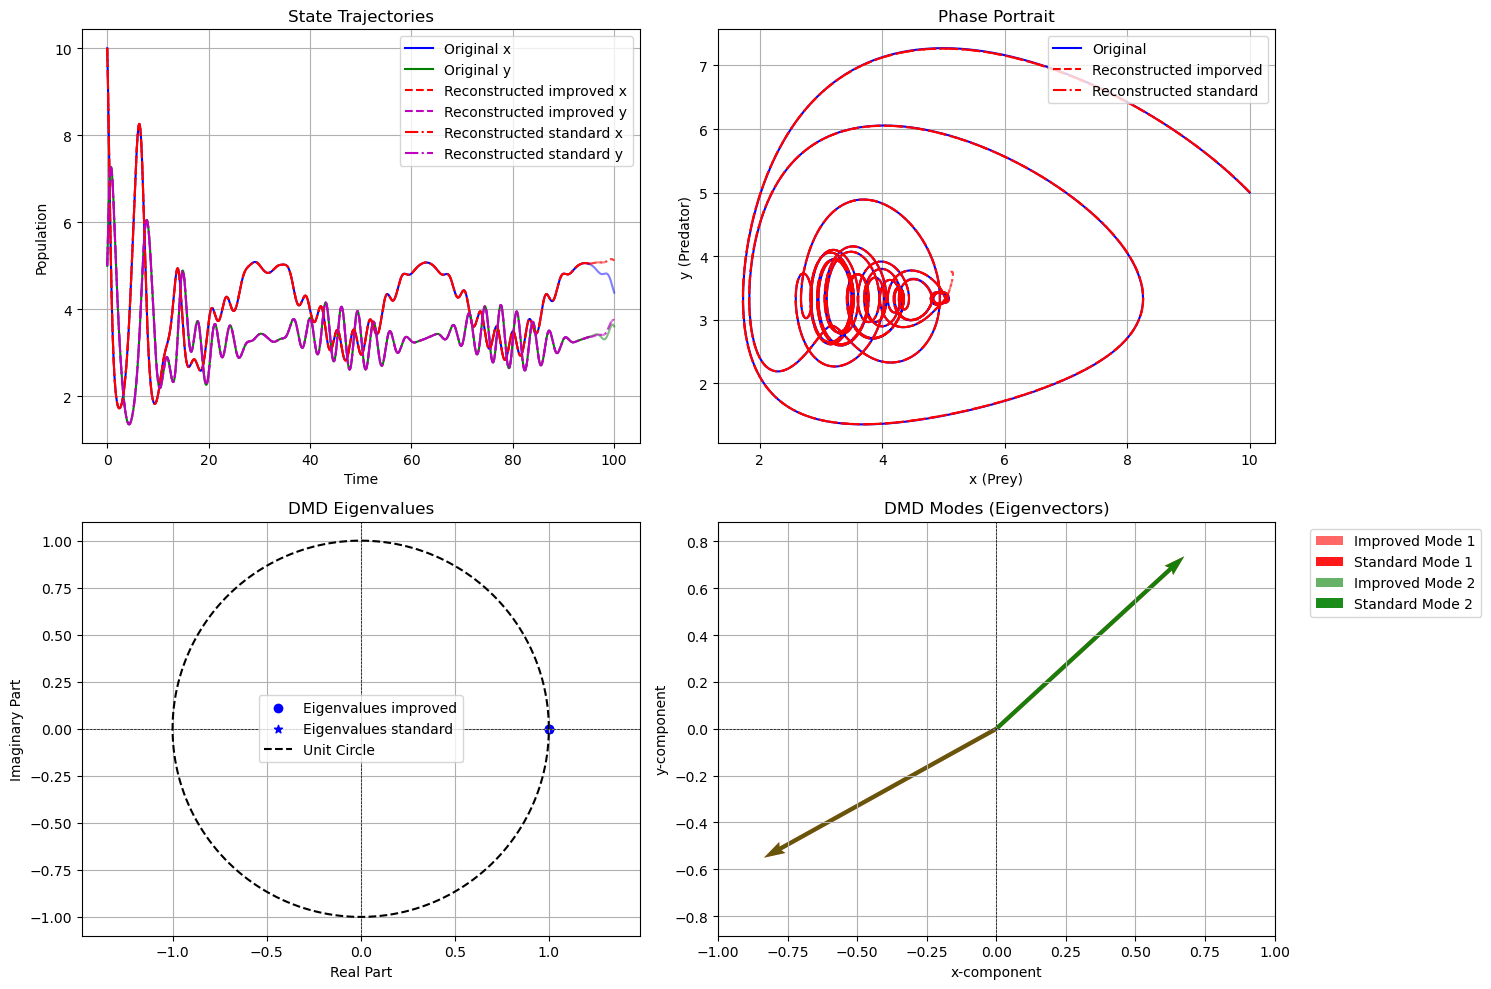

In [8]:
# Create a figure with subplots
plt.figure(figsize=(15, 10))

# Subplot 1: State Trajectories
plt.subplot(2, 2, 1)
plt.plot(t_array[:N_train-1], X_data[0, :-1], 'b-', label='Original x')
plt.plot(t_array[:N_train-1], X_data[1, :-1], 'g-', label='Original y')
plt.plot(t_array[:N_train-1], recons[0, :], 'r--', label='Reconstructed improved x')
plt.plot(t_array[:N_train-1], recons[1, :], 'm--', label='Reconstructed improved y')
plt.plot(t_array[:N_train-1], recons_std[0, :], 'r-.', label='Reconstructed standard x')
plt.plot(t_array[:N_train-1], recons_std[1, :], 'm-.', label='Reconstructed standard y')
# for prediction
plt.plot(t_array[N_train:], x_solved[N_train:], 'b-', alpha=0.5)
plt.plot(t_array[N_train:], y_solved[N_train:], 'g-', alpha=0.5)
plt.plot(t_array[N_train:], Y_pred[0, :], 'r--', alpha=0.5)
plt.plot(t_array[N_train:], Y_pred[1, :], 'm--', alpha=0.5)
plt.plot(t_array[N_train:], Y_pred_std[0, :], 'r-.', alpha=0.5)
plt.plot(t_array[N_train:], Y_pred_std[1, :], 'm-.', alpha=0.5)

plt.title('State Trajectories')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)

# Subplot 2: Phase Portrait
plt.subplot(2, 2, 2)
plt.plot(X_data[0, :-1], X_data[1, :-1], 'b-', label='Original')
plt.plot(x_solved[N_train-1:], y_solved[N_train-1:], 'b-', alpha=0.5)
plt.plot(recons[0, :], recons[1, :], 'r--', label='Reconstructed imporved')
plt.plot(Y_pred[0, :], Y_pred[1, :], 'r--', alpha=0.5)
plt.plot(recons_std[0, :], recons_std[1, :], 'r-.', label='Reconstructed standard')
plt.plot(Y_pred_std[0, :], Y_pred_std[1, :], 'r-.', alpha=0.5)
plt.title('Phase Portrait')
plt.xlabel('x (Prey)')
plt.ylabel('y (Predator)')
plt.legend()
plt.grid(True)

# Subplot 3: Eigenvalues with Unit Circle
plt.subplot(2, 2, 3)
plt.scatter(eigenvalues.real, eigenvalues.imag, c='b', marker='o', label='Eigenvalues improved')
plt.scatter(eigenvalues_std.real, eigenvalues_std.imag, c='b', marker='*', label='Eigenvalues standard')
theta = np.linspace(0, 2 * np.pi, 400)
plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle')
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
plt.title('DMD Eigenvalues')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.legend()
plt.axis('equal')
plt.grid(True)

# Subplot 4: DMD Modes (Eigenvectors)
plt.subplot(2, 2, 4)
origin = np.zeros((2, modes.shape[1]))

# Find axis limits to keep all vectors inside the figure
x_max = np.max(np.abs(modes[0, :].real)) * 1.2
y_max = np.max(np.abs(modes[1, :].real)) * 1.2

num_modes = min(min(modes.shape[1], modes_std.shape[1]), 6)  # Plot up to 6 eigenvectors
colors = ['r', 'g']
print("the number of modes", num_modes)
for i in range(num_modes):
    vec_imp = modes[:, i].real
    vec_std = modes_std[:, i].real
    plt.quiver(0, 0, vec_imp[0], vec_imp[1], angles='xy', scale_units='xy', scale=1, color=colors[i % len(colors)], alpha=0.6, linewidth=1.5, label=f'Improved Mode {i+1}')
    plt.quiver(0, 0, vec_std[0], vec_std[1], angles='xy', scale_units='xy', scale=1, color=colors[i % len(colors)], alpha=0.9, linewidth=2.5, linestyle='-.', label=f'Standard Mode {i+1}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('DMD Modes (Eigenvectors)')
plt.xlabel('x-component')

plt.ylabel('y-component')
plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)
plt.grid(True)

# # Adjust layout and save the figure
plt.tight_layout()
plt.show()

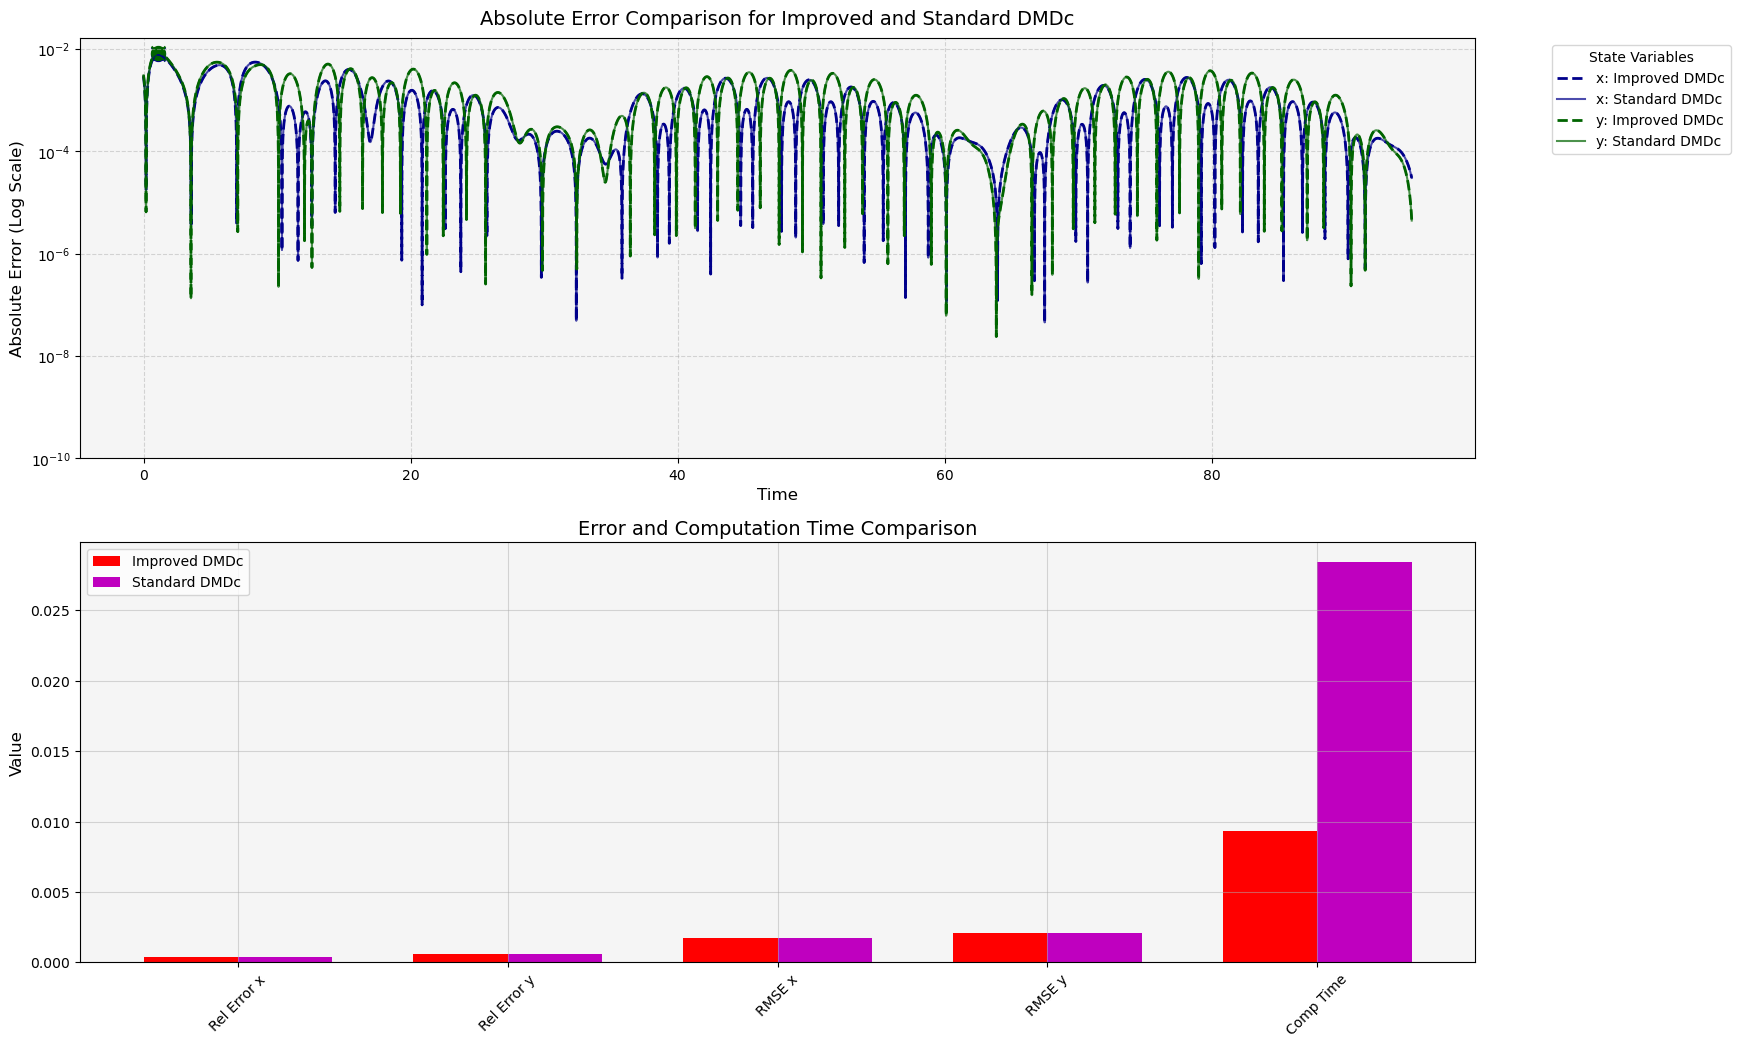

In [9]:
# Create figure with 2 subplots
fig = plt.figure(figsize=(18, 12))

# Plot 1: Absolute Error Comparison (Improved)
ax5 = fig.add_subplot(211)
abs_error_improved = np.abs(X_data[:, :-1] - recons)
abs_error_std = np.abs(X_data[:, :-1] - recons_std)

# Plot errors with grouped colors and different line styles
ax5.plot(t_array[:N_train-1], abs_error_improved[0, :], color='darkblue', linestyle='--', label='x: Improved DMDc', linewidth=2.0)
ax5.plot(t_array[:N_train-1], abs_error_std[0, :], color='darkblue', linestyle='-', label='x: Standard DMDc', linewidth=1.5, alpha=0.7)
ax5.plot(t_array[:N_train-1], abs_error_improved[1, :], color='darkgreen', linestyle='--', label='y: Improved DMDc', linewidth=2.0)
ax5.plot(t_array[:N_train-1], abs_error_std[1, :], color='darkgreen', linestyle='-', label='y: Standard DMDc', linewidth=1.5, alpha=0.7)

# Annotate peak errors for each variable
for i, var in enumerate(['x', 'y']):
    max_idx_imp = np.argmax(abs_error_improved[i, :])
    max_idx_std = np.argmax(abs_error_std[i, :])
    ax5.scatter(t_array[max_idx_imp], abs_error_improved[i, max_idx_imp], color='darkblue' if i == 0 else 'darkgreen' if i == 1 else 'darkcyan', marker='o', s=100)
    ax5.scatter(t_array[max_idx_std], abs_error_std[i, max_idx_std], color='darkblue' if i == 0 else 'darkgreen' if i == 1 else 'darkcyan', marker='x', s=100)

ax5.set_title('Absolute Error Comparison for Improved and Standard DMDc', fontsize=14, pad=10)
ax5.set_xlabel('Time', fontsize=12)
ax5.set_ylabel('Absolute Error (Log Scale)', fontsize=12)
ax5.set_yscale('log')  # Logarithmic scale for better visibility
ax5.set_ylim(bottom=1e-10)  # Avoid log scale issues with zero
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title='State Variables')
ax5.grid(True, which="both", ls="--", alpha=0.5)
ax5.set_facecolor('#f5f5f5')  # Light background for contrast

# Plot 2: Error and Time Metrics (Unchanged)
ax6 = fig.add_subplot(212)
metrics = ['Rel Error x', 'Rel Error y', 'RMSE x', 'RMSE y', 'Comp Time']
values_improved = [rel_error_improved[0], rel_error_improved[1],  rmse_improved[0], rmse_improved[1],  time_improved]
values_std = [rel_error_std[0], rel_error_std[1],  rmse_std[0], rmse_std[1], time_standard]
x = np.arange(len(metrics))
width = 0.35
ax6.bar(x - width/2, values_improved, width, label='Improved DMDc', color='r')
ax6.bar(x + width/2, values_std, width, label='Standard DMDc', color='m')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics, rotation=45)
ax6.set_title('Error and Computation Time Comparison', fontsize=14)
ax6.set_ylabel('Value', fontsize=12)
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.5)
ax6.set_facecolor('#f5f5f5')

# plt.tight_layout()
# plt.savefig('dmdc_error_comparison_improved.png')

DMDc Eigenvalues: [1.00001709 0.99927661]
DMDc Modes shape: 
 [[-0.83496401  0.67536527]
 [-0.55033562  0.73650221]]


/home/phuc/.local/lib/python3.10/site-packages/pydmd/plotter.py:195: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x76ce4128b0a0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(


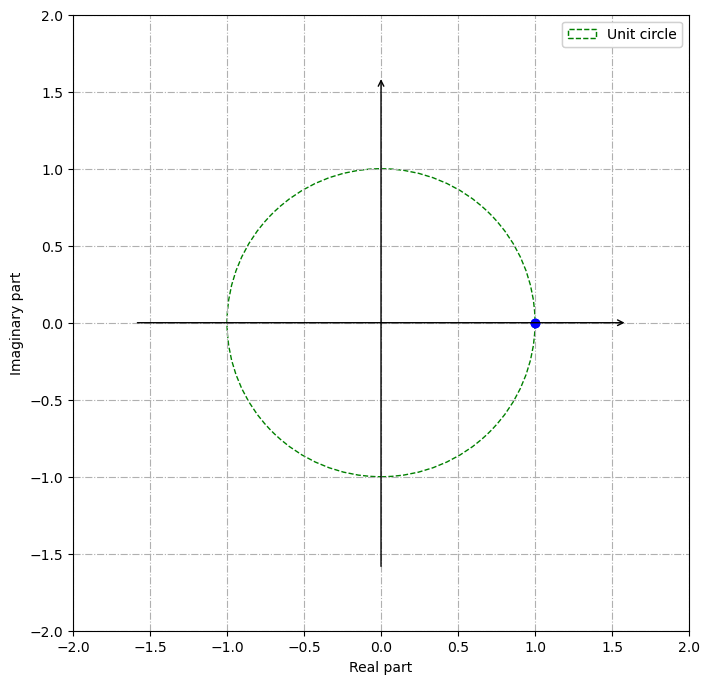

In [10]:
from pydmd import DMD, DMDc
from pydmd.plotter import plot_eigs
#Compute DMDc using the corresponding classes in PyDMD package

dmdc = DMDc(svd_rank=-1)
dmdc.fit(X_data, U_control)
# plot_eigs(dmdc)
print("DMDc Eigenvalues:", dmdc.eigs)
print("DMDc Modes shape: \n", dmdc.modes)
plot_eigs(dmdc)

[legend.py:1217 -   _parse_legend_args() ] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


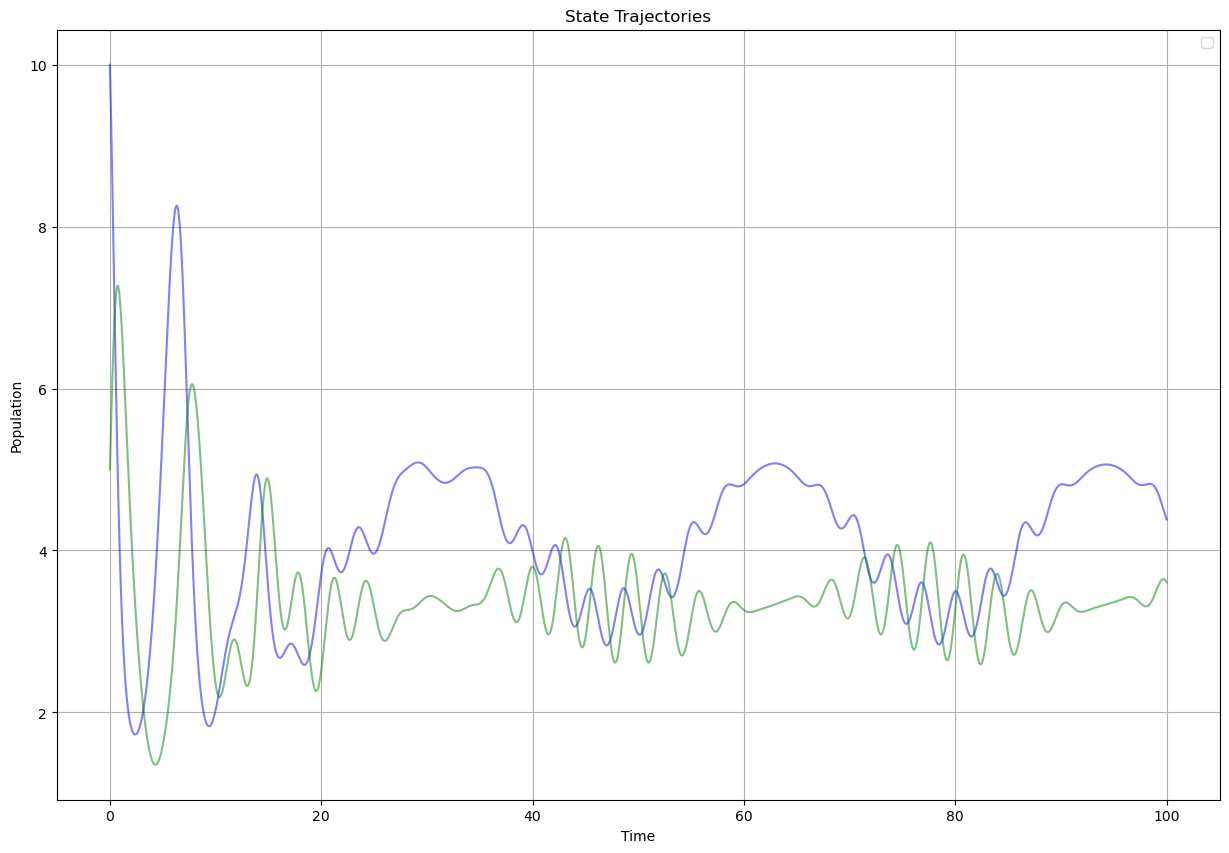

In [11]:
# Create a figure with subplots
plt.figure(figsize=(15, 10))

# # Subplot 1: State Trajectories
# plt.subplot(2, 2, 1)
plt.plot(t_array[:], x_solved[:], 'b-', alpha=0.5)
plt.plot(t_array[:], y_solved[:], 'g-', alpha=0.5)

# the prediction from pyDMDc

dmdc.dmd_time["dt"] = t_array[1] - t_array[0]
dmdc.dmd_time["t0"] = t_array[0]
dmdc.dmd_time["tend"] = t_array[-1]

# print("the shape of dynamics is", (dmdc.dynamics.shape[-1] - dmdc._lag))
# print("the shape of U", u_con.T.reshape(1,-1).real.shape)
# predicted_pydmdc = dmdc.reconstructed_data(u_con.T.reshape(1,-1).real)
# plt.plot(t_array[:], predicted_pydmdc[0, :-1], 'r.-', alpha=0.5, label='Reconstruction pyDMD x')
# plt.plot(t_array[:], predicted_pydmdc[1, :-1], 'm.-', alpha=0.5, label='Reconstruction pyDMD y')

plt.title('State Trajectories')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)

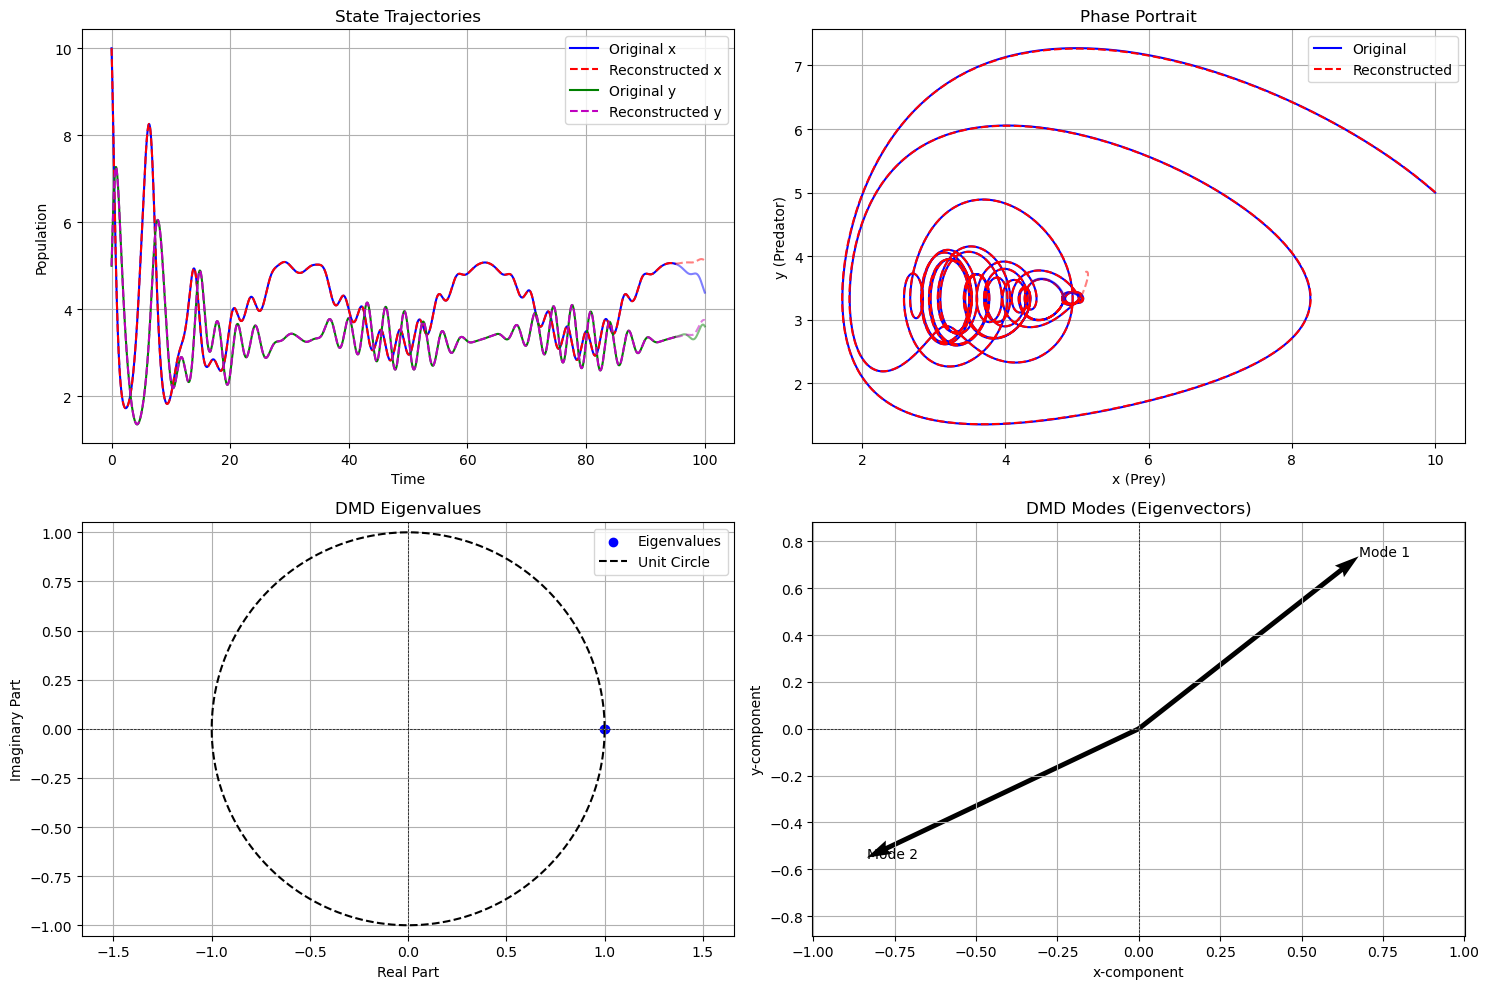

In [12]:
# Create a figure with subplots
plt.figure(figsize=(15, 10))

# Subplot 1: State Trajectories
plt.subplot(2, 2, 1)
plt.plot(t_array[:N_train-1], X_data[0, :-1], 'b-', label='Original x')
plt.plot(t_array[:N_train-1], recons[0, :], 'r--', label='Reconstructed x')
plt.plot(t_array[:N_train-1], X_data[1, :-1], 'g-', label='Original y')
plt.plot(t_array[:N_train-1], recons[1, :], 'm--', label='Reconstructed y')
plt.plot(t_array[N_train:], x_solved[N_train:], 'b-', alpha=0.5)
plt.plot(t_array[N_train:], y_solved[N_train:], 'g-', alpha=0.5)
plt.plot(t_array[N_train:], Y_pred[0, :], 'r--', alpha=0.5)
plt.plot(t_array[N_train:], Y_pred[1, :], 'm--', alpha=0.5)

# the prediction from pyDMDc

# dmdc.dmd_time["dt"] = t_array[1] - t_array[0]
# dmdc.dmd_time["t0"] = t_array[0]
# dmdc.dmd_time["tend"] = t_array[-1]
# print("the shape of U", u_con.shape)
# predicted_pydmdc = dmdc.reconstructed_data(u_con.T[:-1].reshape(1,-1).real)
# plt.plot(t_array[N_train:], predicted_pydmdc[0, N_train:], 'r.-', alpha=0.5, label='Reconstruction pyDMD x')
# plt.plot(t_array[N_train:], predicted_pydmdc[1, N_train:], 'm.-', alpha=0.5, label='Reconstruction pyDMD y')

plt.title('State Trajectories')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)

# Subplot 2: Phase Portrait
plt.subplot(2, 2, 2)
plt.plot(X_data[0, :-1], X_data[1, :-1], 'b-', label='Original')
plt.plot(recons[0, :], recons[1, :], 'r--', label='Reconstructed')
plt.plot(x_solved[N_train-1:], y_solved[N_train-1:], 'b-', alpha=0.5)
plt.plot(Y_pred[0, :], Y_pred[1, :], 'r--', alpha=0.5)
plt.title('Phase Portrait')
plt.xlabel('x (Prey)')
plt.ylabel('y (Predator)')
plt.legend()
plt.grid(True)

# Subplot 3: Eigenvalues with Unit Circle
plt.subplot(2, 2, 3)
plt.scatter(eigenvalues.real, eigenvalues.imag, c='b', marker='o', label='Eigenvalues')
theta = np.linspace(0, 2 * np.pi, 400)
plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle')
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
plt.title('DMD Eigenvalues')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.legend()
plt.axis('equal')
plt.grid(True)

# Subplot 4: DMD Modes (Eigenvectors)
plt.subplot(2, 2, 4)
origin = np.zeros((2, modes.shape[1]))

# Find axis limits to keep all vectors inside the figure
x_max = np.max(np.abs(modes[0, :].real)) * 1.2
y_max = np.max(np.abs(modes[1, :].real)) * 1.2

plt.quiver(origin[0], origin[1], modes[0, :].real, modes[1, :].real, angles='xy', scale_units='xy', scale=1)
for i in range(modes.shape[1]):
    plt.text(modes[0, i].real, modes[1, i].real, f'Mode {i+1}', fontsize=10)
plt.title('DMD Modes (Eigenvectors)')
plt.xlabel('x-component')
plt.ylabel('y-component')
plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)
plt.grid(True)

# # Adjust layout and save the figure
plt.tight_layout()
# plt.savefig('lotka_volterra_dmdc_analysis.png')
# plt.close()
plt.show()

# benchmark for big problem, or some special matrix

# apply POD 